### Project Overview   
In this project, I'm building a tool to predict how much it costs to rent an apartment in Poland using a Random Forest Regressor. If you're someone renting out your apartment, this model can help you decide on the right rental price. It's also handy for people looking to rent, giving them an idea of what to expect in terms of pricing based on certain features.

### Data Source   
https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland/data

### Data Fields
- city - the name of the city where the property is located  
- type - type of the building  
- squareMeters - the size of the apartment in square meters  
- rooms - number of rooms in the apartment  
- floor / floorCount - the floor where the apartment is located and the total number of floors in the building  
- buildYear - the year when the building was built  
- latitude, longitude - geo coordinate of the property  
- centreDistance - distance from the city centre in km  
- poiCount - number of points of interest in 500m range from the apartment (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)  
- [poiName]Distance - distance to the nearest point of interest (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)  
- ownership - the type of property ownership  
- condition - the condition of the apartment  
- has[features] - whether the property has key features such as assigned parking space, balcony, elevator, security, storage room  
- price - offer price in Polish Zloty (sale offers: sale price, rent offers: monthly rent)


#### Import libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#apartment rental data
#rent_2023_11 = pd.read_csv('data\\raw\\apartments_rent_pl_2023_11.csv')
#rent_2023_11 = rent_2023_11.assign(date='November 2023')
# Podwójne ukośniki

import os

file_path = os.path.join(os.getcwd(), 'data', 'raw', 'apartments_rent_pl_2023_11.csv')
rent_2023_11 = pd.read_csv(file_path)



#rent_2023_12 = pd.read_csv('Apartment_Prices_in_Poland\data\raw\apartments_rent_pl_2023_12.csv')
#rent_2023_12 = rent_2023_12.assign(date='December 2023')

#rent_2024_01 = pd.read_csv('Apartment_Prices_in_Poland\data\raw\apartments_rent_pl_2024_01.csv')
#rent_2024_01 = rent_2023_12.assign(date='January 2024')


#df = pd.concat([rent_2023_11, rent_2023_12, rent_2024_01])

#df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\python\\Apartment_Prices_in_Poland\\notebooks\\data\\raw\\apartments_rent_pl_2023_11.csv'

#### Data Cleaning
Data cleaning based on previous project: Apartments for rent in Warsaw EDA

In [3]:
# convert to numerical values
df['type_numerical'] = pd.factorize(df['type'])[0]
df['condition_numerical'] = pd.factorize(df['condition'])[0]
df['city_numerical'] = pd.factorize(df['city'])[0]

df = df.drop('type', axis=1)
df = df.drop('condition', axis=1)
#df = df.drop('city', axis=1)

df['hasElevator'].fillna('yes', inplace=True)

columns_to_change = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
maping = {'yes': 1, 'no': 0}
df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
df=df.drop('id', axis=1)
df=df.drop('date', axis=1)


# removing rare, unimportant columns
rare_columns = ['buildYear', 'buildingMaterial','condition_numerical',
                'schoolDistance', 'clinicDistance','kindergartenDistance','restaurantDistance','collegeDistance',
                'pharmacyDistance','postOfficeDistance','ownership']
df.drop(columns=rare_columns, inplace=True)


# null values
median_type = df['type_numerical'].median()
median_floor = df['floor'].median()
median_floorCount = df['floorCount'].median()

df['type_numerical'].fillna(median_type, inplace=True)
df['floor'].fillna(median_floor, inplace=True)
df['floorCount'].fillna(median_floorCount, inplace=True)

#price column moved to the end
temp_column = df.pop('price')
df['price'] = temp_column

#removing outliers
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound)&(df['price'] <= upper_bound)]

df.head()


,city,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,szczecin,52.0,2.0,3.0,3.0,53.460535,14.545416,4.26,2.0,1,1,0,0,0,0,0,3500
1,szczecin,57.0,3.0,3.0,10.0,53.440955,14.566024,1.98,14.0,0,1,1,0,0,0,0,3000
2,szczecin,43.4,2.0,3.0,4.0,53.435746,14.560764,1.37,17.0,0,1,0,0,0,-1,0,1900
3,szczecin,32.6,2.0,5.0,6.0,53.421582,14.541572,1.30,16.0,0,1,1,0,0,1,0,2500
4,szczecin,72.0,3.0,6.0,6.0,53.450010,14.547230,3.10,11.0,0,1,1,0,1,1,0,2999


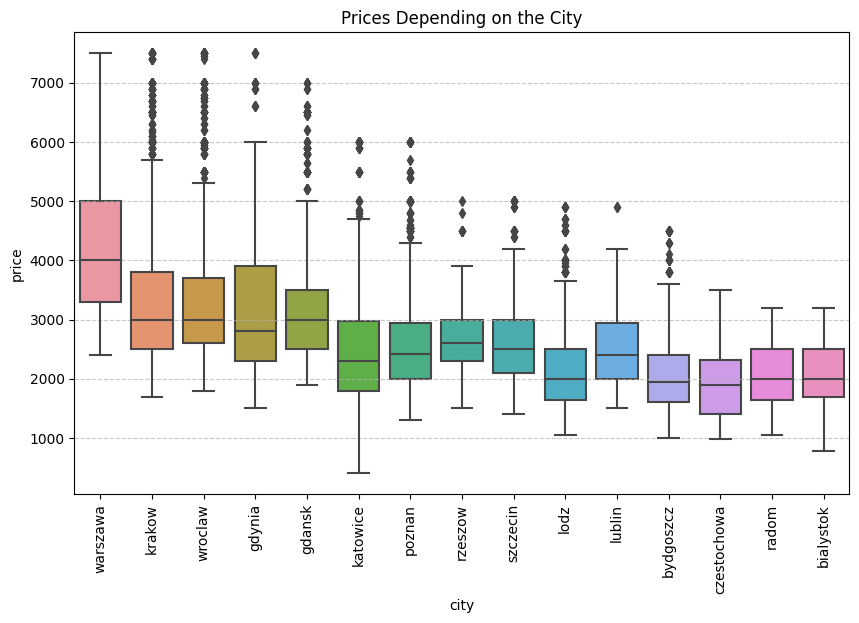

In [4]:
df_sorted = df.sort_values(by='price', ascending=False)
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price', data=df_sorted)

plt.xlabel('city')
plt.ylabel('price')
plt.title('Prices Depending on the City')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [5]:
df=df.drop('city',axis=1)

#### Split into training and testing data

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



#### Random Forest Regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


#### Evaluation for Random Forest

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')


MSE: 117569.81751191184
MAE: 210.39801423859026
R-squared: 0.9372922111325718


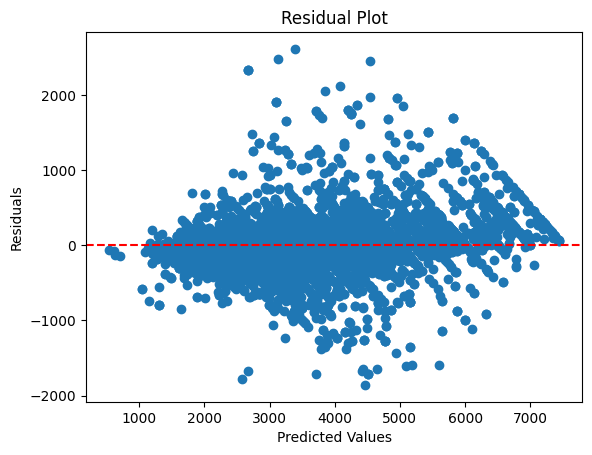

In [9]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


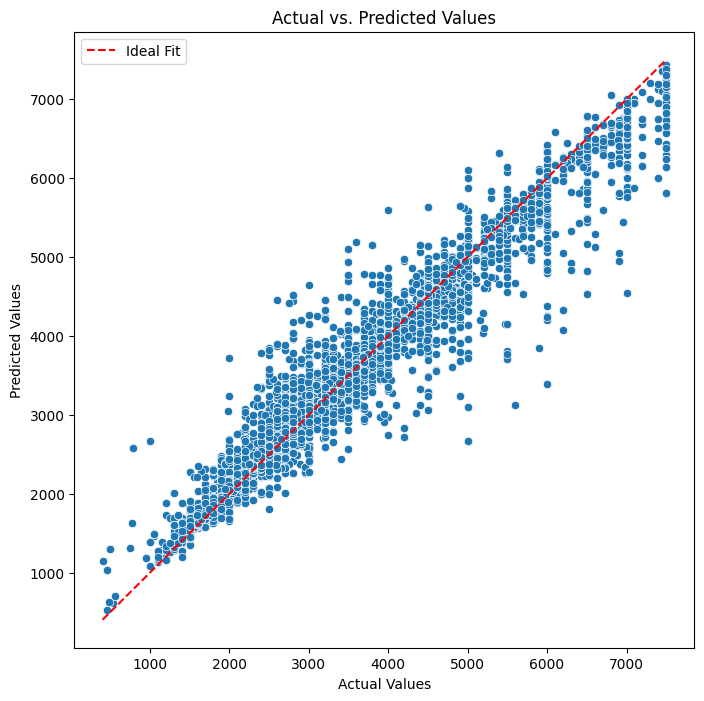

In [10]:

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


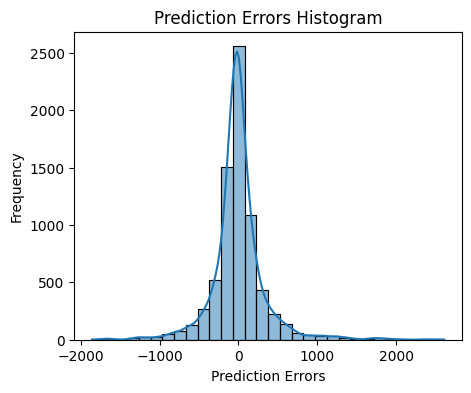

In [11]:
errors = y_test - y_pred

plt.figure(figsize=(5, 4))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Prediction Errors Histogram')
plt.show()



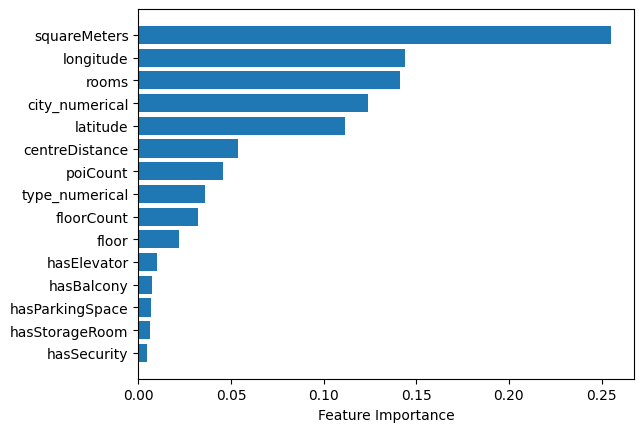

In [12]:
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [13]:
# used parameters
params = rf_model.get_params()

print("Random Forest model parameters:")
for param, value in params.items():
    print(f"{param}: {value}")


Random Forest model parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 20
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
